In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import LinearNDInterpolator
rng = np.random.default_rng() # random number generator

## Configuration and CSV file ingestion

In [88]:
masses = np.arange(9, 31) # Msun
mass_range = np.linspace(np.min(masses)-0.499, np.max(masses)+0.499, int(1e4))

coupling = -10

isotopes = [
    'c12', 
    'o16', 
    'ne20', 
    'na23',
]

# what we read from the CSV files
labels = list(({
    # 'model': 'slice',
    'm': 'mass (Msun)',
    # 'coupling': 'coupling',
    # 'age': 'age (years)',
    'til': 'time to core O depletion (years)',
    # 'dt': 'dt (years)',
    
    # 'm_enc': 'mass enclosed (Msun)',
    # 'dm': 'dm (g)',
    # 'r': 'r (Rsun)',
    # 'dr': 'dr (cm)',
    # 'T': 'T (K)',
    # 'T_core': 'core T (K)',
    # 'T_eff': 'effective T (K)',
    # 'log_T': 'log T',
    
    # 'eps_grav': 'eps_grav (ergs/g s)',
    # 'eps_nuc': 'eps_nuc (ergs/g s)', 
    # 'eps_non_nuc_neu': 'eps_neu (ergs/g s)',
    # 'eps_a': 'eps_a (ergs/g s)',
    
    # 'lum_gamma': 'lum_gamma (ergs/s)',
    # 'lum_neu': 'lum_neu (ergs/s)',
    # 'lum_a': 'lum_a (ergs/s)',
    
    'lum_gamma_surf': 'surface lum_gamma (ergs/s)',
    # 'lum_neu_surf': 'surface lum_neu (ergs/s)',
    'lum_a_surf': 'surface lum_a (ergs/s)',
    # 'num_a_surf': 'surface num_a (/s)',
    
    # 'cum_e_gamma': 'cumulative e_gamma (ergs)',
    # 'cum_e_neu': 'cumulative e_neu (ergs)',
    # 'cum_e_a': 'cumulative e_a (ergs)',
}).values())

lumSun = 3.846e33 # ergs/s
cm_per_kpc = 3.086e21
max_slices = 100000000
num_per_erg = 1.41853e6 # /erg

In [8]:
datatable = dict()

for m in masses:
    try:
        key = f'm{m:04.1f}_g{coupling:+04.2f}_0'
        # run = pd.read_csv(f'csv/{key}/index.csv')
        run = pd.read_csv(f'csv_simplified/index{m:02}.csv')
        entry = run[labels].to_numpy()[:max_slices].T
        datatable[m] = entry
        print(key, end=',\t')
    except FileNotFoundError as e:
        print(e)

m09.0_g-10.00_0,	m10.0_g-10.00_0,	m11.0_g-10.00_0,	m12.0_g-10.00_0,	m13.0_g-10.00_0,	m14.0_g-10.00_0,	m15.0_g-10.00_0,	m16.0_g-10.00_0,	m17.0_g-10.00_0,	m18.0_g-10.00_0,	m19.0_g-10.00_0,	m20.0_g-10.00_0,	m21.0_g-10.00_0,	m22.0_g-10.00_0,	m23.0_g-10.00_0,	m24.0_g-10.00_0,	m25.0_g-10.00_0,	m26.0_g-10.00_0,	m27.0_g-10.00_0,	m28.0_g-10.00_0,	m29.0_g-10.00_0,	m30.0_g-10.00_0,	

## Probability distributions

In [9]:
s0 = 0.0686 # kpc, bulge radius from galaxy center
se = 8.5 # kpc, earth radius from galaxy center
alpha = 0.74 # Verberne & Vink
beta = -3.52 # Verbene & Vink
fs0 = lambda s: ((s + s0)/se)**alpha * np.exp(beta * (s/se))

z0 = 0.4 # kpc, disk scale height
fz0 = lambda z: np.exp(-np.abs(z)/z0)

def fr0(r):
    theta_range = np.linspace(0, 2*np.pi, 300)
    phi_range = np.linspace(0, np.pi, 300)
    R, Theta, Phi = np.meshgrid(r, theta_range, phi_range)

    zz = np.nan_to_num(R*np.cos(Phi), 0)
    ss = np.nan_to_num(np.sqrt((R*np.sin(Phi))**2 + se**2 - 2*se*R*np.cos(Theta)*np.sin(Phi)), 0)

    return np.sum(
        R*R*np.sin(Phi) * fz0(zz) * fs0(ss),
        axis=(0,2)
   )

norm = lambda x: x / np.sum(x)
fr = lambda r: norm(fr0(r))

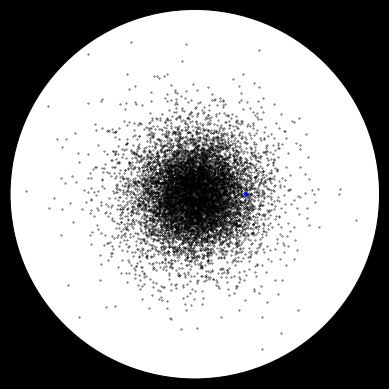

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=100, facecolor='black')
ax.set_rmin(0)
ax.set_rmax(30)
ax.set_rticks([])  # Move radial labels away from plotted line
ax.grid(False)
ax.set_thetagrids([])

# ax.set_title("A line plot on a polar axis", va='bottom')

srange = np.linspace(0, 30, 10000)
trange = np.linspace(0, 2*np.pi, 10000)
sp = norm(2*np.pi * srange * fs0(srange))
size = 10000
schoice = np.random.choice(srange, size=size, p=sp)
tchoice = np.random.choice(trange, size=size)
ax.scatter(tchoice, schoice, s=0.1, color='black')
ax.scatter([0], [se], s=5, color='blue')

In [93]:
r_range = np.linspace(0, 30, 200)
graph = fr(r_range)

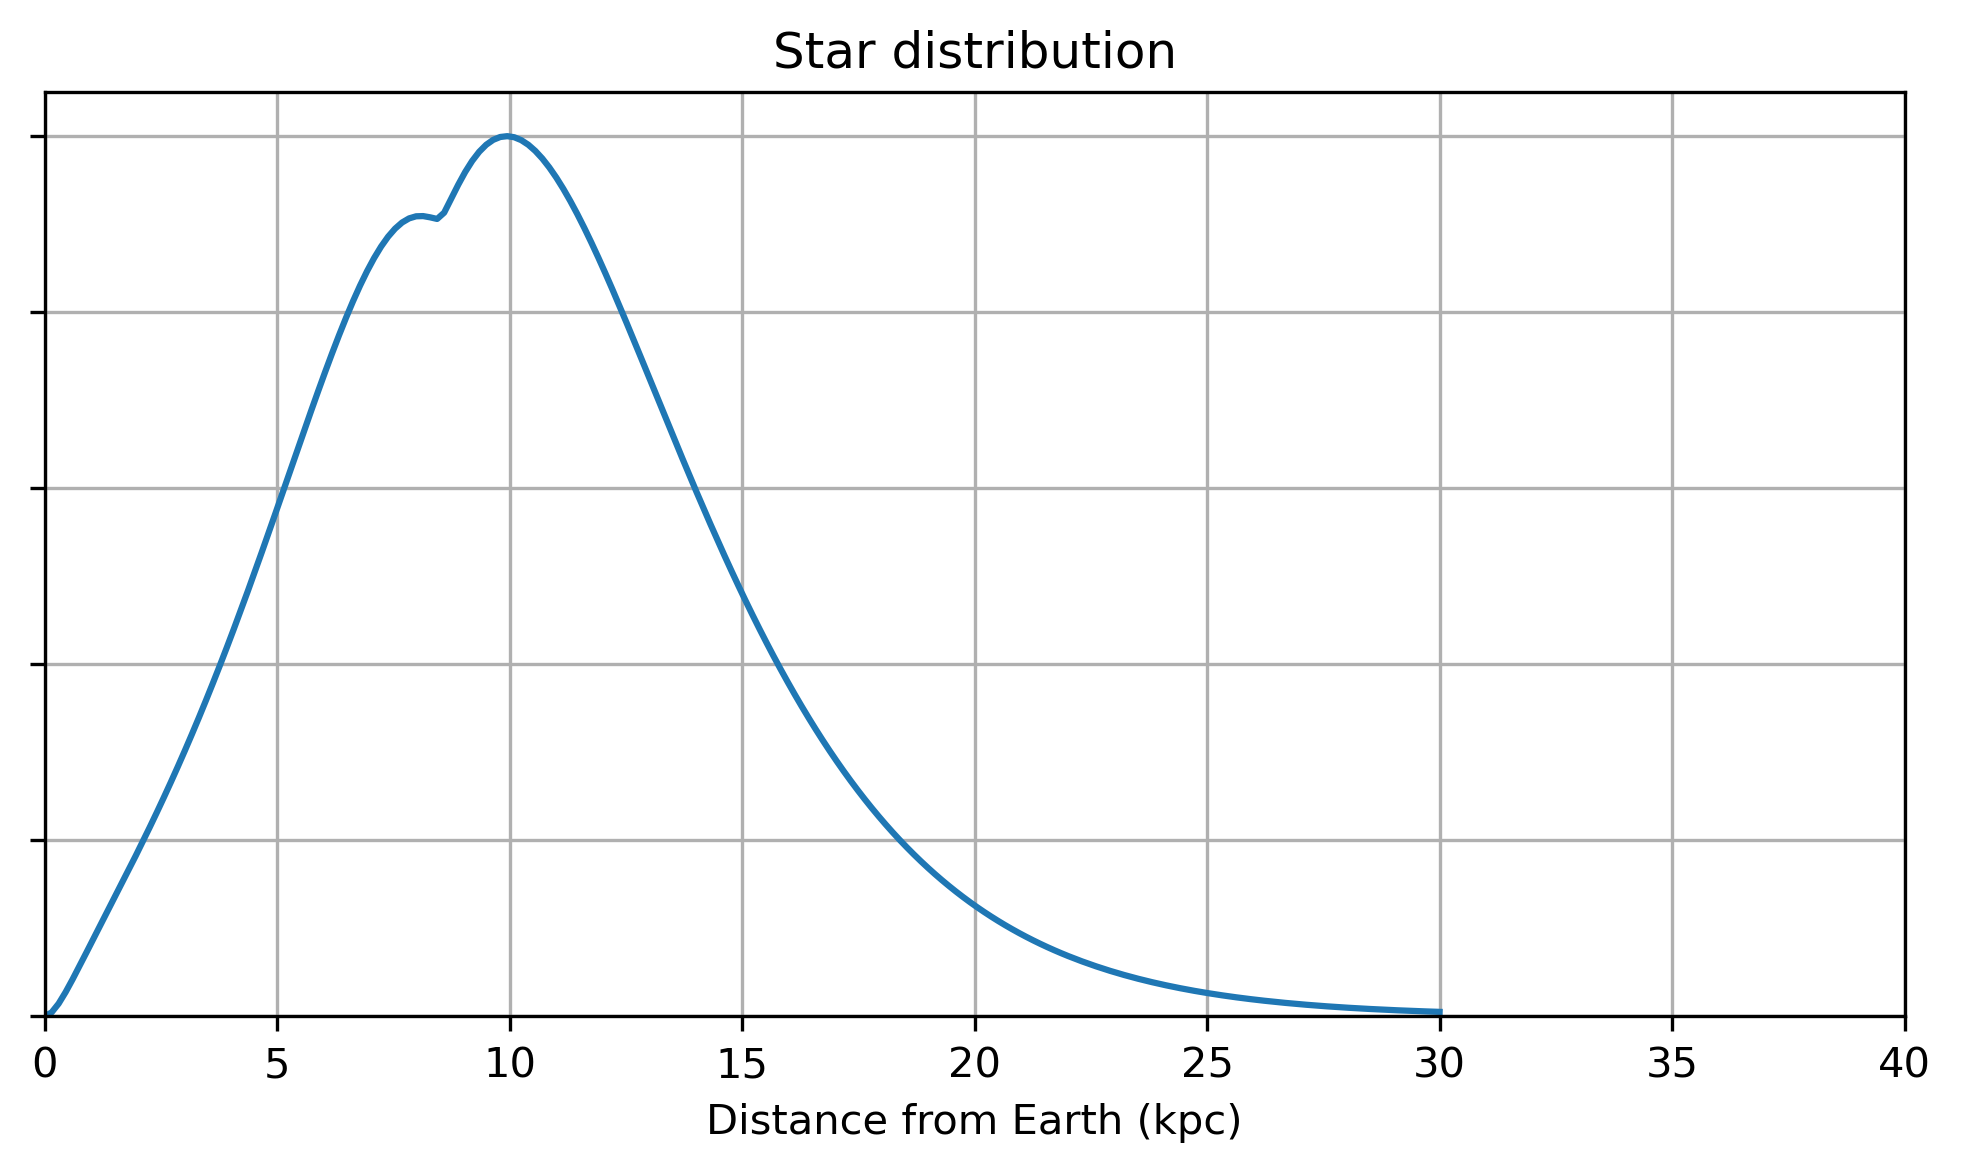

In [94]:
fig, ax = plt.subplots(dpi=300, facecolor='white', figsize=(8, 4))
plt.plot(r_range, graph/np.max(graph))
plt.xlabel("Distance from Earth (kpc)")
# plt.ylabel("Discrete probability")
ax.get_yaxis().set_ticklabels([])
plt.ylim(0)
plt.xlim(0, 40)
plt.title("Star distribution")
plt.grid()

In [13]:
(
    np.sum((graph/r_range**2)[np.logical_and(r_range>0.01, r_range<2.11)])
    /
    np.sum((graph/r_range**2)[r_range>0.01])
)

/tmp/ipykernel_15478/107993713.py:2: RuntimeWarning: invalid value encountered in divide
  np.sum((graph/r_range**2)[np.logical_and(r_range>0.01, r_range<2.11)])
/tmp/ipykernel_15478/107993713.py:4: RuntimeWarning: invalid value encountered in divide
  np.sum((graph/r_range**2)[r_range>0.01])


0.4709551452628646

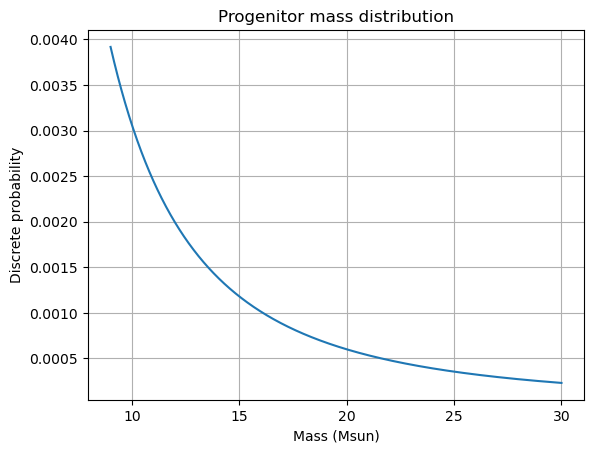

In [14]:
# inverse of initial mass function
imf0 = lambda m: m**(-2.35)
imf = lambda m: norm(imf0(m))
plt.plot(mass_range, imf(mass_range))
plt.grid()
plt.xlabel('Mass (Msun)')
plt.ylabel('Discrete probability')
plt.title("Progenitor mass distribution")
plt.show()

## Sampling

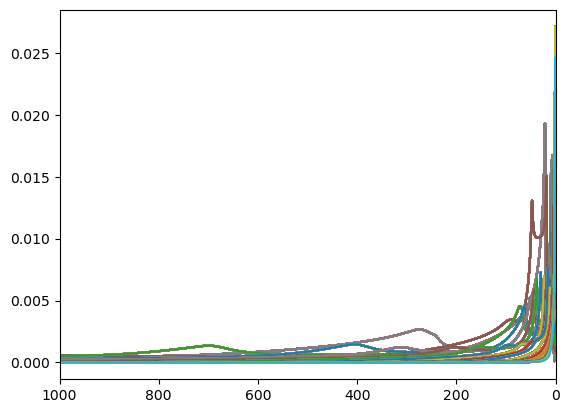

In [27]:
r2 = 4 * np.pi * (7.9716362 * cm_per_kpc)**2
for m in mass_range:
    entry = datatable[np.round(m)]
    t_raw, lum_g_t_raw, lum_a_t_raw = entry[1:]
    plt.plot(t_raw, num_per_erg* lum_a_t_raw/r2)
    plt.xlim(1000, 0)

In [99]:
freq = 1/40 # SN per year
r_range = np.linspace(0, 100, 1000) # kpc
r_pmf = fr(r_range)
m_pmf = imf(mass_range)


In [161]:
m_pmf = imf(mass_range)


In [117]:
for w in range(10):
    t_start = 40*w
    t_end = 40*(1+w) # years
    N_distance = 10
    N_time = 100
    N_SN = 10
    N_loop = 10
    fluxes = []
    for i in range(N_loop):
        flux = 0
        for j in range(N_time):
            t = t_start + (t_end - t_start) * np.random.rand()
            for k in range(N_SN):
                m = int(np.round(np.random.choice(mass_range, p=m_pmf)))
                entry = datatable[m]
                for l in range(N_distance):
                    r = np.random.choice(r_range, p=r_pmf)
                    r2 = 4 * np.pi * (r * cm_per_kpc)**2 # cm^2
                    t_raw, lum_g_t_raw, lum_a_t_raw = entry[1:]
                    # lum_g_t += np.interp(-t, -t_raw, lum_g_t_raw, left=0, right=0) / r2
                    flux += 100 * np.interp(-t, -t_raw, lum_a_t_raw, left=0, right=0) * num_per_erg / r2
    
        fluxes.append(flux * freq * (t_end - t_start) / (N_time * N_SN * N_distance))
    print(t_start, t_end, np.mean(fluxes), np.std(fluxes))

0 40 0.9794192000618599 0.0937823859928206
40 80 0.6122369132098111 0.036512713889535704
80 120 0.36709684841874485 0.03985000095570368
120 160 0.2453728077632022 0.041057093880353474
160 200 0.19590364111995565 0.024101382375871498
200 240 0.17054201232750715 0.026746900604251018
240 280 0.209551804272932 0.04605482234218531
280 320 0.1845237594339368 0.024049543962312608
320 360 0.17712256086441078 0.054772334118643004
360 400 0.163264820816682 0.030223996759593707


(array([6., 2., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.53508739, 0.70635487, 0.87762235, 1.04888983, 1.22015731,
        1.39142478, 1.56269226, 1.73395974, 1.90522722, 2.0764947 ,
        2.24776218]),
 <BarContainer object of 10 artists>)

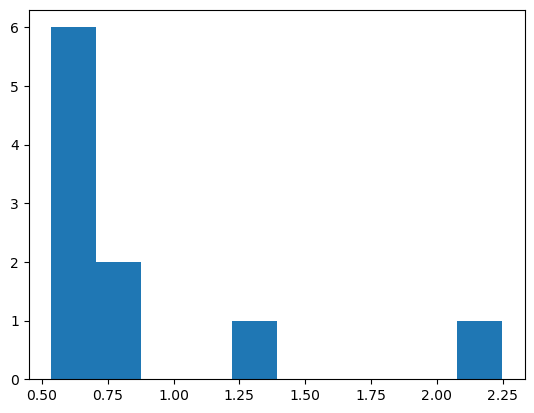

In [112]:
plt.hist(fluxes)

In [162]:
lum_g_list = []
num_a_list = []
g = 1e-9
N_i = 300
for i in range(N_i):
    lum_g_t = 0
    num_a_t = 0
    
    rlist = []
    mlist = []
    nlist = []

    endtime = 100000 # years
    poisson = np.random.poisson(freq, endtime)
    times = np.arange(endtime)[poisson > 0]
    for t0 in times:
        t = t0 + rng.random()
        r = np.random.choice(r_range, p=r_pmf)
        r2 = 4 * np.pi * (r * cm_per_kpc)**2 # cm^2
        m = int(np.round(np.random.choice(mass_range, p=m_pmf)))
        rlist.append(r)
        mlist.append(m)
        
        entry = datatable[m]
        t_raw, lum_g_t_raw, lum_a_t_raw = entry[1:]
    
        lum_g_t += np.interp(-t, -t_raw, lum_g_t_raw, left=0, right=0) / r2
        num_a_t += (g/1e-10)**2 * np.interp(-t, -t_raw, lum_a_t_raw, left=0, right=0) * num_per_erg / r2
        nlist.append((g/1e-10)**2 * np.interp(-t, -t_raw, lum_a_t_raw, left=0, right=0)* num_per_erg)

    lum_g_list.append(lum_g_t)
    num_a_list.append(num_a_t)

    print(100*i//N_i, end=',')
    
    # print(f"{lum_g_t:.3f} photon ergs/cm^2 sec")
    # print(f"{num_a_t:.3f} axions/cm^2 sec")

0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10,10,11,11,11,12,12,12,13,13,13,14,14,14,15,15,15,16,16,16,17,17,17,18,18,18,19,19,19,20,20,20,21,21,21,22,22,22,23,23,23,24,24,24,25,25,25,26,26,26,27,27,27,28,28,28,29,29,29,30,30,30,31,31,31,32,32,32,33,33,33,34,34,34,35,35,35,36,36,36,37,37,37,38,38,38,39,39,39,40,40,40,41,41,41,42,42,42,43,43,43,44,44,44,45,45,45,46,46,46,47,47,47,48,48,48,49,49,49,50,50,50,51,51,51,52,52,52,53,53,53,54,54,54,55,55,55,56,56,56,57,57,57,58,58,58,59,59,59,60,60,60,61,61,61,62,62,62,63,63,63,64,64,64,65,65,65,66,66,66,67,67,67,68,68,68,69,69,69,70,70,70,71,71,71,72,72,72,73,73,73,74,74,74,75,75,75,76,76,76,77,77,77,78,78,78,79,79,79,80,80,80,81,81,81,82,82,82,83,83,83,84,84,84,85,85,85,86,86,86,87,87,87,88,88,88,89,89,89,90,90,90,91,91,91,92,92,92,93,93,93,94,94,94,95,95,95,96,96,96,97,97,97,98,98,98,99,99,99,

In [173]:
num_a_list = np.array(num_a_list)

(0.0, 30.0)

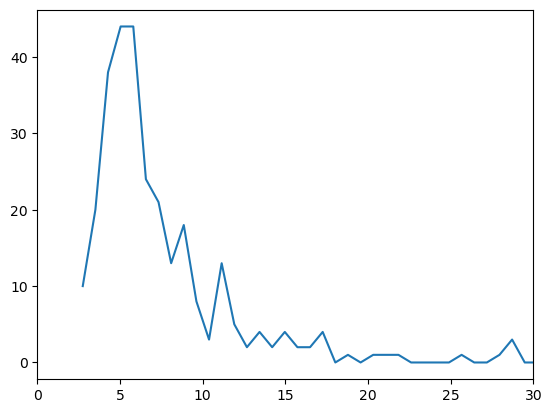

Text(0, 0.5, 'runs')

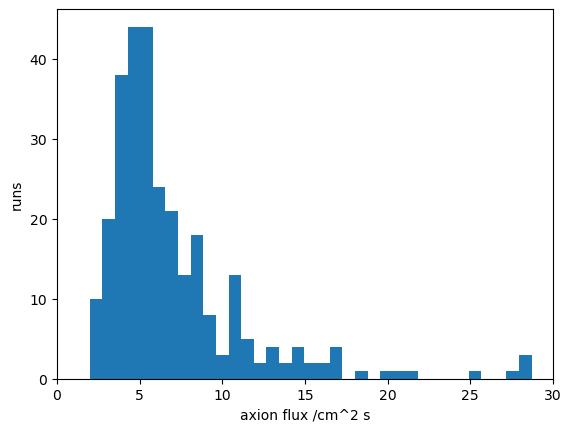

In [170]:
plt.hist(num_a_list, bins=1000)
plt.xlabel("axion flux /cm^2 s")
plt.xlim(0,30)
plt.ylabel('runs')

In [176]:
np.mean(num_a_list[num_a_list<30]), np.std(num_a_list[num_a_list<30])

(7.001714354426614, 4.447431277963141)

In [203]:
def double_gaussian(x, params):
    (a, mu, s1, s2) = params
    return a * ( np.heaviside(x-mu, 0.5) * np.exp(-((x-mu)/(2*s1))**2) + np.heaviside(mu-x, 0.5) * np.exp(-((x-mu)/(2*s2))**2) )
def double_gaussian_fit(params, x, y):
    return y - double_gaussian(x, params)

In [204]:
from scipy.optimize import leastsq
fit, cov = leastsq(double_gaussian_fit, [40, 5, 2, 5], args=(edges[1:], hist))
print('mean', fit[1])
print('left std', fit[2])
print('right std', fit[3])

mean 4.578225950263429
left std 1.97576087571375
right std 0.6992923283326764


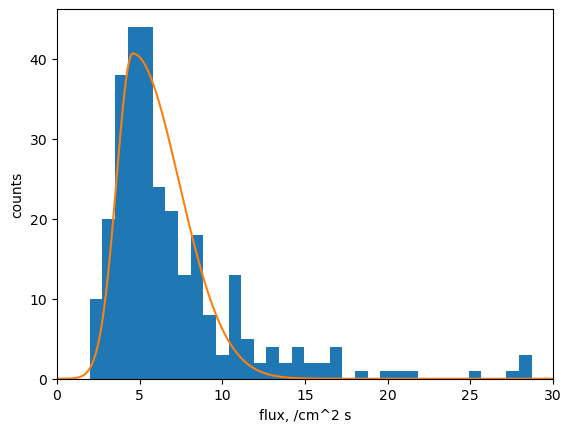

In [208]:
hist, edges = np.histogram(num_a_list, bins=1000)
plt.hist(num_a_list, bins=1000)
space = np.linspace(0,30, 1000)
plt.plot(space, double_gaussian(space, fit))
plt.xlim(0,30)
plt.xlabel('flux, /cm^2 s')
plt.ylabel('counts')
plt.show()

Text(0, 0.5, 'counts')

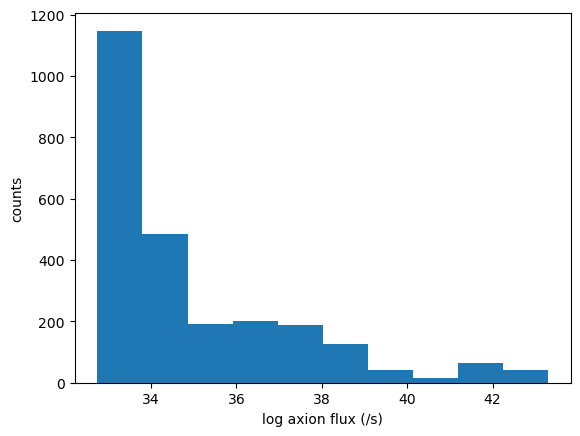

In [29]:
plt.hist(np.log10(nlist), bins=10)
plt.xlabel('log axion flux (/s)')
plt.ylabel('counts')

Text(0, 0.5, 'sample frequency')

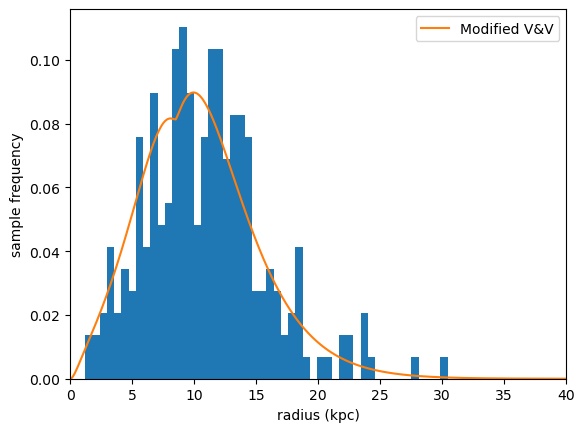

In [46]:
plt.hist(rlist, bins=50, density=True)
plt.plot(r_range, r_pmf*10, label='Modified V&V')
plt.xlim(0,40)
plt.legend()
plt.xlabel('radius (kpc)')
plt.ylabel('sample frequency')

In [42]:
plt.hist(mlist, bins=21, density=True)
plt.plot(masses, m_pmf, label='Salpeter -2.35')
plt.legend()
plt.xlabel('mass (Msun)')
plt.ylabel('sample frequency')

NameError: name 'mlist' is not defined

In [89]:
a = []
for m in masses:
    x = np.sum(m_pmf[(mass_range > m-0.5) & (mass_range <= m+0.5)])
    print(m-0.5, m+0.5,
          x
         )
    a.append(x)

print(np.sum(a))

8.5 9.5 0.1698331656526358
9.5 10.5 0.1321869030827941
10.5 11.5 0.10583369123026716
11.5 12.5 0.08603354434551948
12.5 13.5 0.07141447469354055
13.5 14.5 0.0598513369826788
14.5 15.5 0.05099438333432722
15.5 16.5 0.04371370139660112
16.5 17.5 0.03798715411065264
17.5 18.5 0.033135124492452254
18.5 19.5 0.02924278079894034
19.5 20.5 0.025916293962034518
20.5 21.5 0.02305627874641456
21.5 22.5 0.02071288824300943
22.5 23.5 0.018616276625995867
23.5 24.5 0.016880781009067137
24.5 25.5 0.015302235533850198
25.5 26.5 0.013985136396111536
26.5 27.5 0.012769628558868013
27.5 28.5 0.011749114616687059
28.5 29.5 0.010795015629319008
29.5 30.5 0.009990090558233314
1.0000000000000002
